In [14]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from web3 import Web3
warnings.filterwarnings('ignore')

In [17]:
# Parameters
QUERIED_DATA_PATH = '../Data/queriedData/'
PROCESSED_DATA_PATH = '../Data/processedData/'

token_name = 'AAVE'
end_date = '2022-07-13'

In [29]:
# Read data
agg_tx = pd.read_csv(f"{PROCESSED_DATA_PATH}{token_name}_{end_date}/01_agg_tx.csv")
network_fea = pd.read_csv(f"{PROCESSED_DATA_PATH}{token_name}_{end_date}/02_network_fea.csv")
core_days_cnt = pd.read_csv(f"{PROCESSED_DATA_PATH}{token_name}_{end_date}/03_core_address.csv")

start_date = list(agg_tx['timestamp'].unique())[-1]

# Update basic features
def filter_date(df, start_date, end_date):
    return df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)]

def count_unique_addresses(x):
    addresses = list(x['from_address']) + list(x['to_address'])
    return pd.DataFrame({'address_count': [len(set(addresses))]})

def sum_value(x):
    return pd.DataFrame({'value_sum': [sum(x['value'])]})

network_fea['address_count'] = agg_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']
network_fea['value_sum'] = agg_tx.groupby('timestamp').apply(sum_value).reset_index().drop(columns=['level_1'])['value_sum']
network_fea['day'] = network_fea.index

In [30]:
# Print out some info
def cal_address(agg_df):
    return len(set(list(agg_df['from_address'].unique()) + list(agg_df['to_address'].unique())))

print(f'Duration: {len(network_fea)} days')
print(f'Total Transaction Value: {sum(agg_tx.value)} Dai')
print(f'Number of Addresses: {cal_address(agg_tx)}')

Duration: 649 days
Total Transaction Value: 3.510682967343212e+26 Dai
Number of Addresses: 371122


In [21]:
# Get the core addresses
def get_core_neighbor(tx_df):
    # Construct daily tx graph
    G = nx.from_pandas_edgelist(
        tx_df, 'from_address', 'to_address', 'value', nx.Graph())

    # Detecting discrete core-periphery structure
    alg = cpnet.Lip()   # alg = cpnet.MINRES()
    alg.detect(G)
    x = alg.get_coreness()

    # Calculate avg_core_neighbor
    core_addresses = [a for a in x if x[a] == 1]
    # get their degrees
    degree = list(dict(G.degree(core_addresses)).values())
    # average number of degree, i.e., avg_core_neighbor
    avg_core_neighbor = np.mean(degree)

    return pd.DataFrame({'num_core': [len(core_addresses)],
                         'avg_core_neighbor': [avg_core_neighbor],
                         'core_addresses': [core_addresses]})


# Get the core addresses for each day
fea_core = agg_tx.reset_index().groupby('timestamp').apply(get_core_neighbor).reset_index()

# Produce core addresses list and their days count
core_addresses_list = [core_address for core_addresses in list(fea_core.core_addresses) for core_address in core_addresses]
core_days_cnt = pd.Series(core_addresses_list).value_counts(ascending=False).reset_index()
core_days_cnt.columns = ['address', 'core_days_cnt']

core_days_cnt


,address,core_days_cnt
0,0x4da27a545c0c5b758a6ba100e3a049001de870f5,642
1,0xd75ea151a61d06868e31f8988d28dfe5e9df57b4,635
2,0xdfc14d2af169b0d36c4eff567ada9b2e0cae044f,607
3,0x25f2226b597e8f9514b3f68f00f494cf4f286491,555
4,0x26a78d5b6d7a7aceedd1e6ee3229b372a624d8b7,516
...,...,...
345,0x519bf4613ce9db811a0cd8e55fe0857125cac848,1
346,0x3b04e6632be922392367b0e199ad19462e117e83,1
347,0x8e53ea8f27793728e860e84bdbb9a8826df5bcaf,1
348,0xbe644da9d84b8292410026213c1094fc22ea4bfe,1


In [22]:
# Query the type of core addresses (CA or EOA)
def get_CA_EOA(core_address):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d'
    web3 = Web3(Web3.HTTPProvider(infura_url))

    core_address['type'] = core_address['address'].apply(lambda x: 1 if web3.eth.get_code(Web3.toChecksumAddress(x)).hex()=='0x' else 0)
    core_CA = core_address[core_address['type'] == 0]
    core_EOA = core_address[core_address['type'] == 1]

    CA_str = 'CA ({:.4}%)'.format(100*len(core_CA)/len(core_address))
    EOA_str = 'EOA ({:.4}%)'.format(100*core_EOA.shape[0]/core_address.shape[0])

    print('CA VS EOA: {} {} | {} {}'.format(len(core_CA), CA_str, core_EOA.shape[0], EOA_str))

    return {
        'core_address':core_address[core_address['address'] != '0x0000000000000000000000000000000000000000'], 
        'CA_str': CA_str, 
        'EOA_str': EOA_str
        }

core_address_dict = get_CA_EOA(core_days_cnt)
core_address = core_address_dict['core_address']
CA_str = core_address_dict['CA_str']
EOA_str = core_address_dict['EOA_str']
core_days_cnt

CA VS EOA: 74 CA (21.14%) | 276 EOA (78.86%)


,address,core_days_cnt,type
0,0x4da27a545c0c5b758a6ba100e3a049001de870f5,642,0
1,0xd75ea151a61d06868e31f8988d28dfe5e9df57b4,635,0
2,0xdfc14d2af169b0d36c4eff567ada9b2e0cae044f,607,0
3,0x25f2226b597e8f9514b3f68f00f494cf4f286491,555,0
4,0x26a78d5b6d7a7aceedd1e6ee3229b372a624d8b7,516,1
...,...,...,...
345,0x519bf4613ce9db811a0cd8e55fe0857125cac848,1,1
346,0x3b04e6632be922392367b0e199ad19462e117e83,1,1
347,0x8e53ea8f27793728e860e84bdbb9a8826df5bcaf,1,1
348,0xbe644da9d84b8292410026213c1094fc22ea4bfe,1,1


In [ ]:
# Save the results
core_days_cnt.to_csv(f'{PROCESSED_DATA_PATH}03_core_address.csv', index=False)
print(f'Saved > {PROCESSED_DATA_PATH}03_core_address.csv')

### Visualization

In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
FIG_SAVE_PATH = '../Figure/'
FIG_SAVE_PATH = f"{FIG_SAVE_PATH}{token_name}_{start_date}-{end_date}"

In [31]:
# Figure 1: Basic Info
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("Daily Addresses Count", "Daily Transaction Volume (Wei)"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['address_count']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['value_sum']),
    row=2, col=1
)

fig.update_yaxes(type="log", row=2, col=1)

fig.update_layout(height=700, width=800, showlegend=False, margin=dict(l=20, r=20, t=20, b=20))
fig.show()

fig.write_image(f"{FIG_SAVE_PATH}/fig1.png")

In [32]:
# Figure 2: Core Addresses
core_CA = core_address[core_address['type']==0]['core_days_cnt']
core_EOA = core_address[core_address['type']==1]['core_days_cnt']

fig = go.Figure()
fig.add_trace(go.Box(y=core_CA, name=CA_str))
fig.add_trace(go.Box(y=core_EOA, name=EOA_str))

fig.update_layout(barmode='stack', height=1500, width=500, showlegend=False)

fig.write_image(f"{FIG_SAVE_PATH}/fig2.png")

In [33]:
# Figure 3: Feature Dynamics
fig = make_subplots(
    rows=2, 
    cols=3,
    subplot_titles=(
        "Number of components", 
        "Giant component size ratio", 
        "Modularity", 
        "Std of degree centrality",
        "Number of core nodes",
        "Avg. degree of core nodes"
    ),
    horizontal_spacing=0.05, 
    vertical_spacing=0.1,
)

# LUSD
fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_components']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['giant_com_ratio']),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['modularity']),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['degree_centrality_std']),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_core']),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['avg_core_neighbor']),
    row=2, col=3
)

# fig.update_yaxes(type="log", row=1, col=1)
# fig.update_yaxes(type="log", row=2, col=2)

fig.update_layout(height=700, width=1400, showlegend=False, margin=dict(l=20, r=20, t=20, b=20),)
fig.show()

fig.write_image(f"{FIG_SAVE_PATH}/fig3.png")

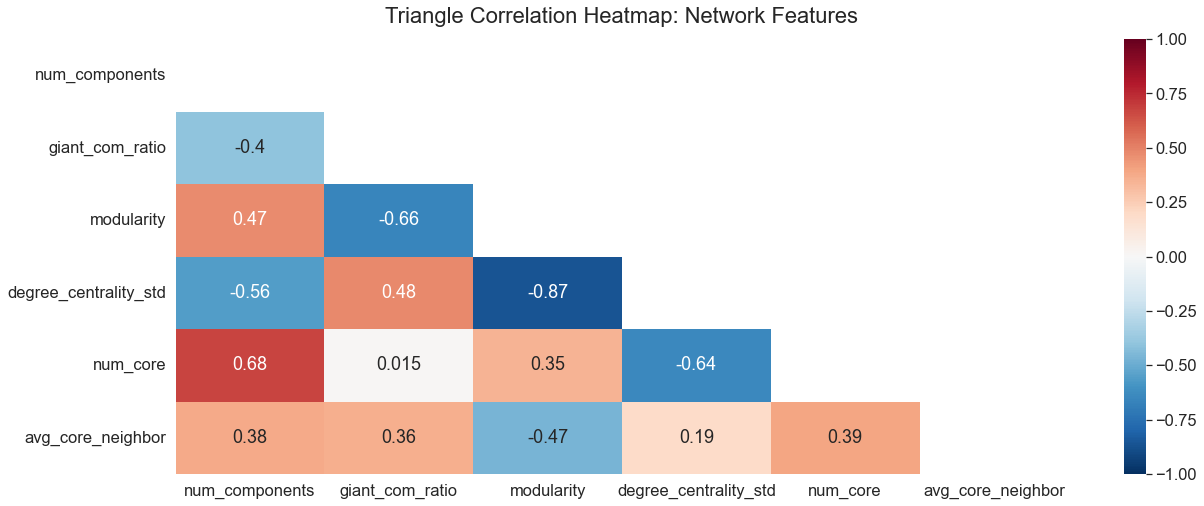

In [34]:
# Figure 4: Feature Correlation
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'num_core', 'avg_core_neighbor']].corr()

plt.style.use('default')
plt.figure(figsize=(20, 8))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Triangle Correlation Heatmap: Network Features', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f"{FIG_SAVE_PATH}/fig4.png", dpi=100)